Final Project, Part 1: Proposal
========================
Frame your problem, criteria, and data source(s)

Describe your chosen problem and state whether you have access to relevant data. If you get stuck, see this list of curated datasets.

Requirements
Draft a well-formed problem statement relevant to a business problem affecting your team, division, or organization.
Include the following elements:
Hypothesis/assumptions
Goals and success metrics
Risks or limitations
Identify at least one relevant internal dataset and confirm that you have (or can get) the right access permissions.
Submission
Submit or share your project proposal as per your instructor's directions.


INTRODUCTION:

https://www.lendingclub.com promises returns far in excess of typical bank deposit rates.

The web site gives an analysis on returns versus risk.  Returns are correlated to:

Loan Tenor
Credit worthiness of borrower
Year of loan origination

The site also explains that granularity (diversification of investment) increases the predictability of return / reduces the range of outcomes.

The site finally gives an example of expected returns:

Average Interest Rate              14%
Effect of chargoffs / prepayments  -8%
LendingClub fee                    -1%

                                 => 5%

PROJECT:

Which variables included in the data set provide the best indicators of loan performance (loan status = fully paid or current) other than the ones provided in the website and is there a way to optimise the returns generated?   Examples of variables:

Loan purpose (business / auto / person)
Interest rate (burden on borrower)
Income and its verification status
County

Is the example return a fair indication given the data set (given the example ave IR = 14% vs the data set is 12.99%)?

LIMITATIONS:

The number of loans that have actually defaulted versus the entire data set is small.
There are a lot of columns that have missing data.
The original data set is very big (>500mb).
What would be key indicators of loan performance such as FICO - are not available anymore in the data.
Different years / vintages of loan give radically different outcomes.  Investigate.
There are a lot of categorical variables.

Part 2: Brief
==========    
Exploratory data analysis is a crucial step in any data workflow. Create a Jupyter Notebook that explores your data mathematically and visually. Explore features, apply descriptive statistics, look at distributions, and determine how to handle sampling or any missing values.

Requirements

Create an exploratory data analysis notebook.

Done

Perform statistical analysis, along with any visualizations.

As per below

Determine how to handle sampling or missing values.

There is a *lot* of data and a lot of columns
    >  I have removed all the columns with >50% data missing
    >  I have also taken a random sample size of 20% of the data for doing to exploration - runs faster
    >  I have also removed object columns such 'title' or 'URL' that hold no value for the anlaysis

The are 10 types of loan status - we are simply concerned if a loan will repay or not
    >  I categorised 3 of the loan status = GOOD LOAN  (eg fully paid)
    >  I categorised 7 of the loan status = BAD  LOAN
    
With the existing variables in the data set I have done some box plots
    >  Interest rate vs GOOD LOAN / BAD LOAN
    >  Debt to Income ration vs GOOD LOAN / BAD LOAN
    >  Loan size vs GOOD LOAN / BAD LOAN

There are a lot of categorical variables / objects
    >  These will need encoding into 1/0 (yes / no integers) for modeling
    >  I have done this on the loan tenor column but will do on more for the full analysis - eg state
    >  These object columns appear to hold most potential wrt modeling 

Clearly identify shortcomings, assumptions, and next steps.    
    >  In the initial analysis I used all loans - so some loans in arrears might actual end up replaying = GOOD LOAN
       I will seperate loans that have run their course a do a sperate analysis on those

    >  I suspect there with be some multi colinearity between the features - such as interest rate and state...
    >  Interest rate should be a function of the risk of default so look at removing these from the model
       
    >  Next steps will be to select the categorical variables we want to use and change them into integers using
       Ordered (1,2,3 etc) and unordered dummy encoding..
    
    >  Select the variables in the model (feature columns)
    >  Train and fit the model using a sample of data using SK Learn and the 'test train split function'
    >  Test the model and compare to a null baseline
    >  Use MSE and RMSE to evaluate the preformance of the model

## Importing data and models

In [1]:
import pandas as pd
import patsy
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

loan = pd.read_csv('lending-club-loan-data/loan.csv')


/Users/User/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Basic examination of data

### Size of data (wide and long) noticable - increase visible rows and experiment on a 20% random sample for speed on computer

In [2]:
pd.set_option('max_columns', 10000)
#so can see all the columns

In [3]:
loan.head()
#lots of NA & categorical data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
loan.shape

(887379, 74)

In [5]:
#Make loan book smaller for initial analysis
loan = loan.sample(frac=0.2, random_state=99)
loan.shape

(177476, 74)

Remove columns with >50% of missing data altogether

Remove columns with objects like URL = no value

Examine the type of data - note large amount of objects / categorical variables

In [6]:
#a lot of NA's
loan.isna().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       10344
emp_length                       9016
home_ownership                      0
annual_inc                          1
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           152261
purpose                             0
title                              29
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         7
earliest_cr_

In [7]:
#remove columns with >50% NA - down to 53 columns
cut = len(loan) * 50 / 100
loan = loan.dropna(thresh=cut, axis=1)
loan.shape

(177476, 53)

In [8]:
#objects like URL EMP TITLE can be removed as will not add to any analysis
loan.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                        2
grade                       7
sub_grade                  35
emp_title               77747
emp_length                 11
home_ownership              5
verification_status         3
issue_d                   103
loan_status                10
pymnt_plan                  2
url                    177476
purpose                    14
title                   15918
zip_code                  887
addr_state                 51
earliest_cr_line          642
initial_list_status         2
last_pymnt_d               97
next_pymnt_d               86
last_credit_pull_d         97
application_type            2
dtype: int64

In [9]:
loan = loan.drop(columns=['url', 'emp_title', 'title'])
loan.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                     2
grade                    7
sub_grade               35
emp_length              11
home_ownership           5
verification_status      3
issue_d                103
loan_status             10
pymnt_plan               2
purpose                 14
zip_code               887
addr_state              51
earliest_cr_line       642
initial_list_status      2
last_pymnt_d            97
next_pymnt_d            86
last_credit_pull_d      97
application_type         2
dtype: int64

In [10]:
loan.describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,1.774760e+05,1.774760e+05,177476.000000,177476.000000,177476.000000,177476,177476.000000,177476.000000,177476,177476,168460,177476,1.774750e+05,177476,177476,177476,177476,177476,177476,177476,177476.000000,177469.000000,177469,177469.000000,177469.000000,177469.000000,1.774760e+05,177392.000000,177469.000000,177476,177476.000000,177476.000000,177476.000000,177476.000000,177476.000000,177476.000000,177476.000000,177476.000000,177476.000000,173850,177476.000000,126953,177464,177444.000000,177476.0,177476,177469.000000,163536.000000,1.635360e+05,1.635360e+05
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7,35,11,5,NaN,3,103,10,2,14,887,51,NaN,NaN,642,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,NaN,86,97,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,36 months,NaN,NaN,B,B3,10+ years,MORTGAGE,NaN,Source Verified,Oct-2015,Current,n,debt_consolidation,945xx,CA,NaN,NaN,Aug-2001,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan-2016,NaN,Feb-2016,Jan-2016,NaN,NaN,INDIVIDUAL,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,123983,NaN,NaN,50857,11217,58365,88721,NaN,66006,9505,120366,177474,104773,1963,25856,NaN,NaN,1313,NaN,NaN,NaN,NaN,NaN,NaN,91108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94386,NaN,110857,145904,NaN,NaN,177379,NaN,NaN,NaN,NaN
mean,3.248782e+07,3.502788e+07,14771.649829,14758.244354,14717.924608,NaN,13.253606,437.050257,NaN,NaN,NaN,NaN,7.510313e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.131340,0.312190,NaN,0.693372,11.527022,0.195392,1.692286e+04,55.119717,25.223921,NaN,8422.901111,8419.508916,7552.439053,7513.903861,5751.598519,1752.998455,0.402781,47.439298,5.133247,NaN,2159.993825,NaN,NaN,0.014314,1.0,NaN,0.005088,221.382619,1.392692e+05,3.206769e+04
std,2.282007e+07,2.410537e+07,8437.091253,8431.146725,8444.407211,NaN,4.377131,244.295782,NaN,NaN,NaN,NaN,6.741903e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.710558,0.853628,NaN,1.001737,5.301526,0.572413,2.239254e+04,23.778618,11.830098,NaN,8498.599006,8495.168771,7853.546880,7828.657899,6620.555973,2081.501199,4.207381,423.517235,67.158545,NaN,4787.730535,NaN,NaN,0.130322,0.0,NaN,0.077080,2195.937546,1.528491e+05,4.035986e+04
min,5.641300e+04,7.299200e+04,500.000000,500.000000,0.000000,NaN,5.320000,15.670000,NaN,NaN,NaN,NaN,1.770000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,9.217709e+06,1.088884e+07,8000.000000,8000.000000,8000.000000,NaN,9.990000,260.850000,NaN,NaN,NaN,NaN,4.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.890000,0.000000,NaN,0.000000,8.000000,0.000000,6.469000e+03,37.700000,17.000000,NaN,0.000000,0.000000,1918.887500,1902.837500,1201.062500,443.892500,0.000000,0.000000,0.000000,NaN,280.407500,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000,2.980700e+04,1.400000e+04
50%,3.443216e+07,3.708662e+07,13000.000000,13000.000000,13000.000000,NaN,12.990000,382.550000,NaN,NaN,NaN,NaN,6.475200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.640000,0.000000,NaN,0.000000,11.000000,0.000000,1.190300e+04,56.000000,24.000000,NaN,6501.440000,6500.000000,4894.825000,4862.510000,3206.795000,1077.220000,0.000000,0.000000,0.000000,NaN,462.950000,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000,8.021800e+04,2.380000e+04
75%,5.481816e+07,

In [11]:
loan.info()

#objects appear to hold a lot of the potential correlations:

#grade                         177476 non-null object
#sub_grade                     177476 non-null object
#emp_length                    168460 non-null object
#home_ownership                177476 non-null object
#verification_status           177476 non-null object
#issue_d                       177476 non-null object
#loan_status                   177476 non-null object
#pymnt_plan                    177476 non-null object
#purpose                       177476 non-null object
#zip_code                      177476 non-null object
#addr_state                    177476 non-null object


<class 'pandas.core.frame.DataFrame'>
Int64Index: 177476 entries, 38778 to 570618
Data columns (total 50 columns):
id                            177476 non-null int64
member_id                     177476 non-null int64
loan_amnt                     177476 non-null float64
funded_amnt                   177476 non-null float64
funded_amnt_inv               177476 non-null float64
term                          177476 non-null object
int_rate                      177476 non-null float64
installment                   177476 non-null float64
grade                         177476 non-null object
sub_grade                     177476 non-null object
emp_length                    168460 non-null object
home_ownership                177476 non-null object
annual_inc                    177475 non-null float64
verification_status           177476 non-null object
issue_d                       177476 non-null object
loan_status                   177476 non-null object
pymnt_plan                    177

## Loan status 

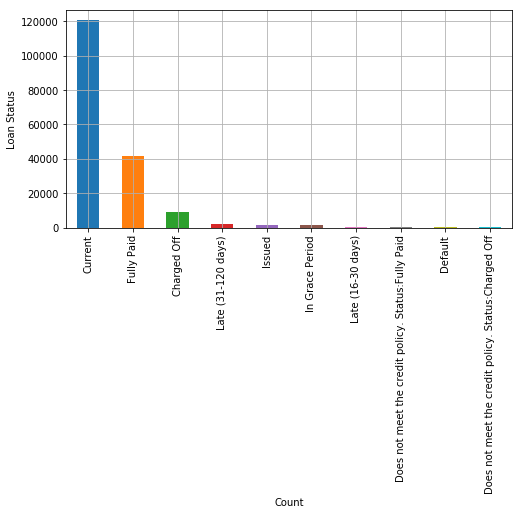

In [12]:
#lets have a look at the status of the various loans
plt.figure(figsize= (8,4))
plt.ylabel('Loan Status')
plt.xlabel('Count')
loan['loan_status'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

we need to know if a loan will perform or not perform... 
categorise each loan status into 2 distinct outcomes - GOOD LOAN or BAD LOAN
I have defined them as per below. 

A flaw with this is that we are looking at both live loans that might be only 1 week old and old loans in the same basket

Possibly split the pool into matured / old loans and look at those seperately 

In [14]:
loan['good_loan'] = np.where((loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Current') | (loan.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 1, 0)
    
index_col = 'good_loan'

Do some exporatory analysis into if a loan is good or bad based on some variables in the data set
I kept the good loan as 1 or 0 - not yes or no - so I can do some correlation analysis on it later

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a214b4cf8>]],
      dtype=object)

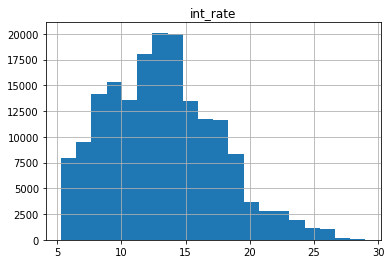

In [16]:
loan.hist(column='int_rate', bins=20)
# histogram as continuous data

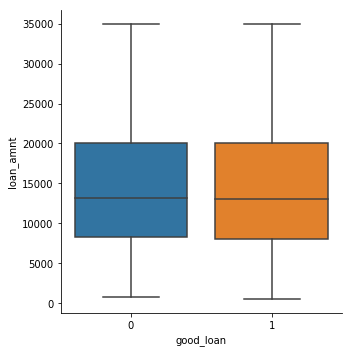

In [17]:
# not correlated to loan size

sns.catplot(x="good_loan", y="loan_amnt", kind="box", data=loan);

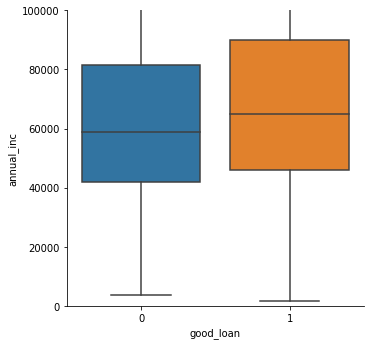

In [18]:
# is correlated to annual income

sns.catplot(x="good_loan", y="annual_inc", kind="box", data=loan).set(ylim=(0, 100000));

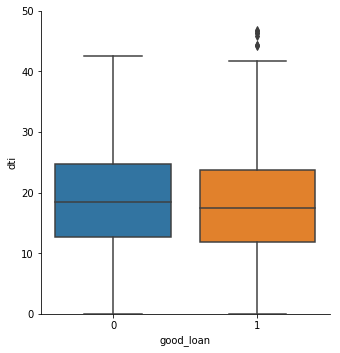

In [19]:
# is correlated to debt to income ratio

sns.catplot(x="good_loan", y="dti", kind="box", data=loan).set(ylim=(0, 50));

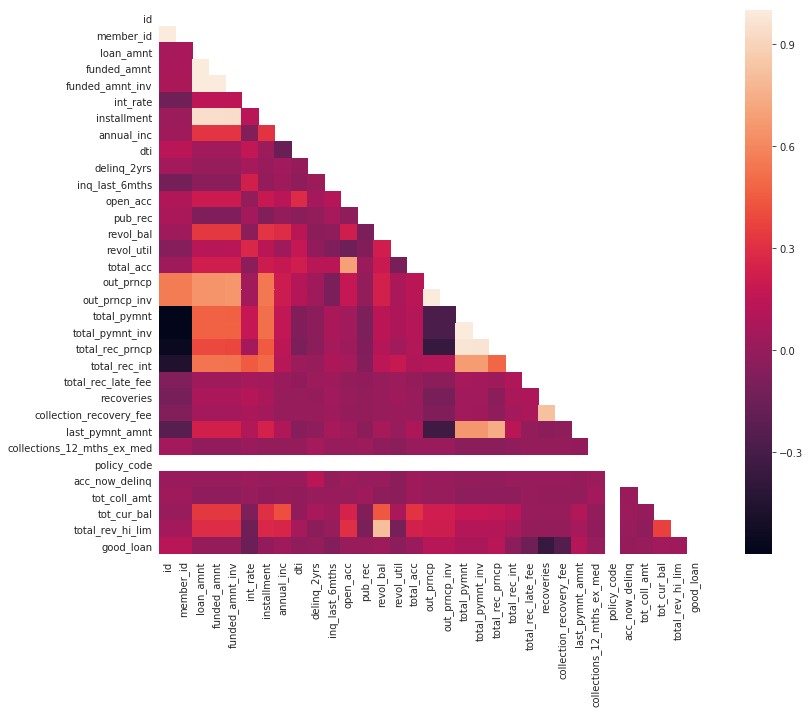

In [20]:
plt.figure(figsize=(15,10))

# Calculate correlation between each pair of variable
corr_matrix=loan.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr_matrix, mask=mask, square=True)

In [60]:
loan.corr()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_loan
id,1.000000,0.999486,0.062727,0.064989,0.070592,-0.142568,0.023362,0.029970,0.131579,0.049068,-0.123874,0.089645,0.079255,0.037579,-0.059025,0.029780,0.558210,0.558177,-0.599187,-0.594424,-0.557936,-0.462728,-0.073328,-0.114319,-0.071970,-0.231632,0.049285,NaN,0.015568,0.026511,0.008588,0.045759,0.126286
member_id,0.999486,1.000000,0.063480,0.065781,0.071496,-0.141709,0.024151,0.030062,0.131732,0.049422,-0.124185,0.089844,0.079966,0.037453,-0.058795,0.030034,0.558683,0.558649,-0.598668,-0.593777,-0.557624,-0.461767,-0.073676,-0.114298,-0.071961,-0.231055,0.049323,NaN,0.015719,0.026561,0.008556,0.045638,0.125893
loan_amnt,0.062727,0.063480,1.000000,0.999243,0.997030,0.143277,0.944748,0.323354,0.038873,0.003245,-0.034459,0.197533,-0.083753,0.336796,0.120097,0.223454,0.647480,0.647480,0.473854,0.474973,0.389340,0.534088,0.035472,0.075400,0.053917,0.228096,-0.014906,NaN,0.002674,-0.018761,0.334450,0.292089,-0.005441
funded_amnt,0.064989,0.065781,0.999243,1.000000,0.997978,0.143332,0.945763,0.322816,0.039599,0.003520,-0.035174,0.198016,-0.083369,0.336616,0.120605,0.223427,0.649457,0.649457,0.472446,0.473781,0.388052,0.532923,0.035138,0.075164,0.053741,0.227595,-0.014743,NaN,0.002781,-0.018761,0.334451,0.292090,-0.004925
funded_amnt_inv,0.070592,0.071496,0.997030,0.997978,1.000000,0.143326,0.943330,0.321758,0.041721,0.003996,-0.039633,0.198599,-0.082282,0.334953,0.121060,0.223513,0.652201,0.652210,0.467937,0.473367,0.383634,0.530417,0.032042,0.072952,0.051295,0.226344,-0.014287,NaN,0.002887,-0.018754,0.334479,0.292131,-0.002442
int_rate,-0.142568,-0.141709,0.143277,0.143332,0.143326,1.000000,0.131664,-0.072503,0.159574,0.057262,0.225907,-0.006454,0.053089,-0.033902,0.268013,-0.032737,0.041795,0.041649,0.170125,0.171060,0.054672,0.445059,0.062192,0.112092,0.075090,0.103192,0.014745,NaN,0.023850,0.004136,-0.092596,-0.153249,-0.157291
installment,0.023362,0.024151,0.944748,0.945763,0.943330,0.131664,1.000000,0.316298,0.025459,0.011324,-0.002931,0.182506,-0.073202,0.320148,0.132898,0.201085,0.546987,0.546982,0.515809,0.516746,0.450124,0.498540,0.046100,0.077814,0.056572,0.239841,-0.010923,NaN,0.006438,-0.015758,0.303983,0.268422,-0.015621
annual_inc,0.029970,0.030062,0.323354,0.322816,0.321758,-0.072503,0.316298,1.000000,-0.167546,0.042821,0.035698,0.129032,-0.008524,0.288118,0.034154,0.178757,0.204203,0.204239,0.157516,0.157367,0.147408,0.124247,0.015413,0.005785,0.005374,0.089976,-0.001980,NaN,0.013487,-0.000229,0.408396,0.258613,0.030915
dti,0.131579,0.131732,0.038873,0.039599,0.041721,0.159574,0.025459,-0.167546,1.000000,-0.002797,-0.019721,0.286318,-0.044168,0.132086,0.171481,0.216285,0.113778,0.113708,-0.080018,-0.077724,-0.101260,0.019535,-0.014164,0.003246,0.004205,-0.057305,-0.002615,NaN,0.007702,-0.012159,-0.014238,0.060276,-0.024084
delinq_2yrs,0.049068,0.049422,0.003245,0.003520,0.003996,0.057262,0.011324,0.042821,-0.002797,1.000000,0.021544,0.051725,-0.009808,-0.031225,-0.016652,0.122606,0.034924,0.034914,-0.031201,-0.030761,-0.037976,0.002946,0.020055,0.000392,0.001478,-0.018833,0.058965,NaN,0.132918,0.001933,0.063194,-0.036899,-0.006071


this correlation matrix really only shows that there is a correlation between good loan and loans that have already started to default..  fields such as 'recoveries'... which are already implied in the good loan status

DTI and annual income give the best correlations

Noticable is the correlation of INTEREST RATE 

## The problem with interest rate is that it is a function of the risk of the loan and hence these varibales already => colinearity.  Cannot use.  But can test our model performance vs that of using good loan vs IR.

The correlations that we are looking for will be in the categorical data such as loan term or state. For example:

In [23]:
loan.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [24]:
loan.addr_state.unique()
#loan.loan_status.unique()
#loan.grade.unique()
#loan.purpose.unique()

array(['TX', 'CA', 'WI', 'UT', 'NC', 'OR', 'PA', 'NY', 'MN', 'SC', 'GA',
       'OK', 'NJ', 'MD', 'IL', 'OH', 'IN', 'MS', 'MA', 'MO', 'VA', 'FL',
       'VT', 'CO', 'MI', 'AZ', 'NH', 'AR', 'KS', 'DE', 'TN', 'RI', 'CT',
       'AL', 'NV', 'WA', 'LA', 'KY', 'WV', 'MT', 'AK', 'WY', 'HI', 'DC',
       'NM', 'ND', 'NE', 'ME', 'SD', 'ID', 'IA'], dtype=object)

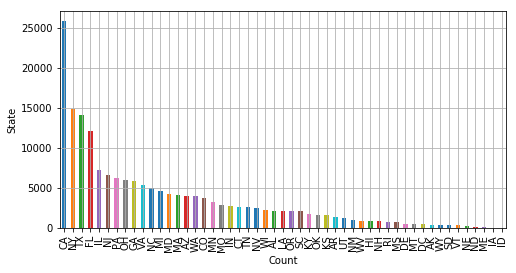

In [25]:
plt.figure(figsize= (8,4))
plt.ylabel('State')
plt.xlabel('Count')
loan['addr_state'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

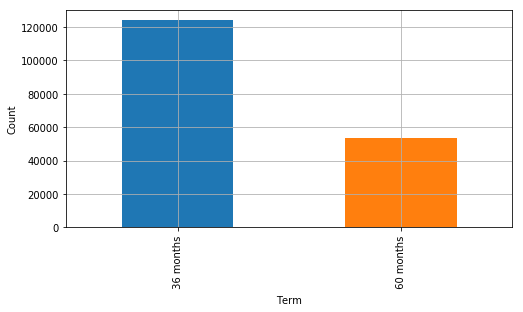

In [26]:
plt.figure(figsize= (8,4))
plt.ylabel('Count')
plt.xlabel('Term')
loan['term'].value_counts().plot(kind = 'bar', grid = True)
plt.show()

# This section deals with sifting through the many categorical variables and elimiating those that are superfluous to reduce size and overfitting of the model.


Do not include the last and next dates and last pull as they are a function of if the loan is defaulted

Convert dates into 2 types - year and month

Year or vintage for if macro economic conditions etc play a part

Month for if season - such as just after xmas when short of money play a part or in the summer etc


In [27]:
#loan_date_columns = loan[['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']]
loan_date_columns = loan[['issue_d','earliest_cr_line']]
#do not include the last and next dates and last pull as they are a function of if the loan is defaulted

#Convert dates into 2 types - year and month
#year or vintage for if macro economic conditions etc play a part
#month for if season - such as just after xmas when short of money play a part or in the summer etc

#loan_date_group_by_year
loan_date_year = loan_date_columns.issue_d.map(lambda x: str(x)[4:])
loan_date_month = loan_date_columns.issue_d.map(lambda x: str(x)[:-5])

early_credit_year = loan_date_columns.earliest_cr_line.map(lambda x: str(x)[4:])
early_credit_month = loan_date_columns.earliest_cr_line.map(lambda x: str(x)[:-5])

loan_date_final = (pd.concat([loan_date_month, loan_date_year,early_credit_month,early_credit_year],axis=1))
loan_date_final.columns = ['Issue_month', 'Issue_year', 'Credit_month','Credit_year']
#loan_date_final = pd.get_dummies(loan_date_final, drop_first=True)
loan_date_final.head()


,Issue_month,Issue_year,Credit_month,Credit_year
38778,May,2008,Aug,2000
225599,Feb,2012,Apr,2004
214742,Jun,2012,Nov,1995
429826,Mar,2014,Jul,2003
282590,Oct,2014,Sep,1988


In [28]:
#   2 >>>>  NON DATE CATEGORICALS 
loan_cat_columns = loan.select_dtypes(include=[np.object])
loan_cat_columns = loan_cat_columns.drop(['zip_code'], axis=1)

#  drop date columns
loan_cat_columns = loan_cat_columns.drop(['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d'], axis=1)

loan_cat_columns.shape


(177476, 12)

## Frustratingly I could not get a feature selection approach to work - the error of requiring boolians kepts coming up despite the data with the categoricals being 1 / 0..  

## The fields eliminated were chosen by trial and error and intuition and the corr matrix

In [29]:
loan_FINAL = (pd.concat([loan.good_loan, loan.int_rate, loan_cat_columns, loan_date_final, loan.loan_amnt, loan.dti, loan.loan_amnt],axis=1))
loan_FINAL = loan_FINAL.drop(columns=['grade', 'sub_grade', 'emp_length', 'home_ownership', 'loan_status','pymnt_plan','purpose','initial_list_status','application_type','Issue_year','Credit_month','Credit_year'])
loan_FINAL.head(5)



,good_loan,int_rate,term,verification_status,addr_state,Issue_month,loan_amnt,dti,loan_amnt
38778,1,10.08,36 months,Not Verified,TX,May,7500.0,16.26,7500.0
225599,1,7.90,36 months,Verified,CA,Feb,10000.0,3.56,10000.0
214742,1,7.90,36 months,Verified,TX,Jun,24000.0,21.55,24000.0
429826,1,14.16,36 months,Verified,WI,Mar,7500.0,25.95,7500.0
282590,1,14.99,36 months,Not Verified,UT,Oct,5000.0,17.64,5000.0


In [80]:
loan_FINAL = pd.get_dummies(loan_FINAL, drop_first=True)
loan_FINAL.shape


(177476, 69)

In [81]:
 loan_FINAL.isnull().sum(axis = 0)

good_loan                              0
int_rate                               0
loan_amnt                              0
dti                                    0
loan_amnt                              0
term_ 60 months                        0
verification_status_Source Verified    0
verification_status_Verified           0
addr_state_AL                          0
addr_state_AR                          0
addr_state_AZ                          0
addr_state_CA                          0
addr_state_CO                          0
addr_state_CT                          0
addr_state_DC                          0
addr_state_DE                          0
addr_state_FL                          0
addr_state_GA                          0
addr_state_HI                          0
addr_state_IA                          0
addr_state_ID                          0
addr_state_IL                          0
addr_state_IN                          0
addr_state_KS                          0
addr_state_KY   

## Final modeling

In [31]:
loan_FINAL2 = loan_FINAL

loan_no_good_no_int = loan_FINAL2.drop(columns=['good_loan', 'int_rate'])
feature_columns1 = list(loan_no_good_no_int.columns.values)

loan_no_good = loan_FINAL2.drop(columns=['good_loan'])
feature_columns2 = list(loan_no_good.columns.values)


In [42]:
X = loan_FINAL2[feature_columns2]
y = loan_FINAL2.good_loan

linreg = LinearRegression()
linreg.fit(X, y)

print(linreg.intercept_)
#list(zip(feature_columns, linreg.coef_))

1.065045955163206


In [43]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(loan_FINAL2, feature_columns2):
    X = loan_FINAL2[feature_columns2]
    y = loan_FINAL2.good_loan
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

## Comparing features 1) Just IR 2) my selection - IR still gives a better indication of loan outcome (good / bad)

In [62]:

print(train_test_rmse(loan_FINAL2, ['int_rate']))
print(train_test_rmse(loan_FINAL2, feature_columns1))

0.2783149594957229
0.28035752359223315


## Comparing to mean estimate for each loan variance = my model only slightly better!  0.2803 vs 0.2818

In [55]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
# Create a NumPy array with the same shape as y_test.
y_null = np.zeros_like(y_test, dtype=float)
# Fill the array with the mean value of y_test.
y_null.fill(y_test.mean())
y_null
np.sqrt(metrics.mean_squared_error(y_test, y_null))

0.28189770106439843

## So interest rate gives a better indication of loan performance than the model.  This is just a sanity check plot to see if IR increases for higher debt to income ratio... which is clearly does

## Performed on a tiny sample to make the graph eligible

## What I do note is actually the huge range of DTI for each IR   eg 12.5% has a DTI 5 > 35

## Suggests their model is also look at the variable we looked at... and possibly more as I note FICO score which was stated as a variable - is no longer available to the public...  which is odd as every borrower will have one and it is a KEY indicator of credit worthyness

/Users/User/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


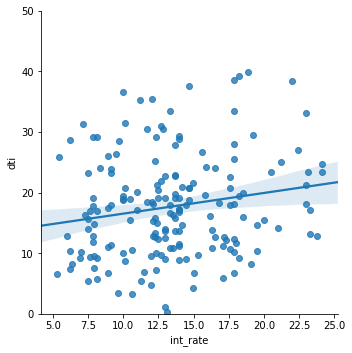

In [57]:
loan_FINAL3 = loan_FINAL2.sample(frac=0.001, random_state=99)
sns.lmplot(x='int_rate', y='dti', data=loan_FINAL3).set(ylim=(0, 50));

# Use K folds method.  See how many folds to optimise the model..

In [64]:
from sklearn.model_selection import cross_val_score

# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)
kf = model_selection.KFold(n_splits=3, shuffle=True)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))


#MSE
#R^2

0.07568770371064087
0.034290348212971465


In [65]:
from sklearn.model_selection import cross_val_score

# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)
kf = model_selection.KFold(n_splits=6, shuffle=True)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))


#MSE
#R^2

0.0756151097096494
0.03462240635665618


In [67]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.07701861019755403
R2: 0.035459287355247504

Model 2
MSE: 0.07617337945840752
R2: 0.03547265626822871

Model 3
MSE: 0.07785257485567877
R2: 0.035458584624021294

Model 4
MSE: 0.07597196084723097
R2: 0.035474556828121284

Model 5
MSE: 0.07375891639117088
R2: 0.03545641103548858

Model 6
MSE: 0.07442625219431244
R2: 0.03546568237040193

Model 7
MSE: 0.0775519303774023
R2: 0.03542803151957552

Model 8
MSE: 0.07584211094221514
R2: 0.03546837915811707

Model 9
MSE: 0.07190692891391308
R2: 0.035428429540895645

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.07561140713087611
Mean of R2 for all folds: 0.03545689096667751


### Little variance across the different approaches...

### Has just occured to me.. maybe because 


## 1) The data set is huge - so different folds etc doesn't have a great affect as data is granular
## 2) Maybe - predicting bad loans is actually difficult - there arent a huge amout 
